# JSON→ECSV converter
This notebook converts digitised curves (WebPlotDigitizer JSON) from a single paper into canonical ECSV datasets for **gDMbounds**, specifically:
- Reads YAML header with publication & dataset metadata (filled by user).
- Loads one or more WPD JSON curves for the same paper/figure.
- Normalizes units to: **mass = GeV**, **σv = cm³ s⁻¹**, **lifetime = s**.
- Writes one ECSV per curve into `dmbounds/bounds/<instrument>` with the filename pattern  
  `<instrument>_<year>_<target>_<mode>_<channel>_<variant>.ecsv`.
- (Optional) Plots a quick smoke-check for the ingested curve(s).

In [2]:
from pathlib import Path
import json, math, re, yaml
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import shlex
import matplotlib.pyplot as plt

from astropy.table import Table, Column, meta
from astropy import units as u
from __future__ import annotations

## Paths and how to run

- BASE — your local clone of `gDMbounds`. Default: `~/gDMbounds`.
- BOUNDS — `BASE/dmbounds/bounds/<instrument>`, the canonical location where ECSV datasets go (1 per curve).
- DATA — `BASE/sandbox/aleksandra_review/data`, a scratch folder for this paper’s `header.yaml` and JSON files.
> Run from anywhere: only adjust `BASE` if your clone lives elsewhere. No other path editing is required.

In [3]:
# === Paths ===
BASE   = Path("~/Soft/gDMbounds").expanduser()
DATA = BASE / "sandbox" / "mdoro/aleksandra" / "data"    # per-paper WPD JSON -> header.yaml
YAML_PATH = DATA / "header.yaml"            # put your header.yaml here
JSON_PATH = DATA / "2509.08506.json"   # your WebPlotDigitizer JSON


BOUNDS  = BASE / "dmbounds" / "bounds"    # base folder for final ECSV
OUT    = BASE / "sandbox" / "mdoro/aleksandra" / "outputs"    # optional output folder for temporary artefacts (e.g., quick plots, non-final ECSV-files)
BOUNDS.mkdir(parents=True, exist_ok=True)
DATA.mkdir(parents=True, exist_ok=True)

## Legends loader (validation helpers)

We read three legend ECSV files and expose:
- `validate_token_set(df, token)` — checks membership (e.g., channel in CHAN_SHORT).
- Accessors to pretty names if needed in titles (not required for writing files).

In [4]:
LEGENDS = BASE / "dmbounds" / "legends"
# === Legends & validators (compact, robust) ===
def _iter_legend_lines(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Legend file not found: {path}")
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.lstrip().startswith("#"):
                continue
            yield ln

def _read_legend_generic(path: Path, kind: str):
    """
    kind = 'two'       → [{'shortname','longname'}]
    kind = 'channels'  → [{'shortname','latex','comment'}]
    """
    it = _iter_legend_lines(path)
    try:
        header = next(it)
    except StopIteration:
        raise ValueError(f"{path.name} is empty")

    if not header.lower().startswith("shortname"):
        raise ValueError(f"Unexpected header in {path.name}: {header}")

    rows = []
    for ln in it:
        parts = shlex.split(ln)
        if len(parts) < 2:
            continue
        if kind == "two":
            short = parts[0]
            longname = " ".join(parts[1:])
            rows.append({"shortname": short, "longname": longname})
        elif kind == "channels":
            short  = parts[0]
            latex  = parts[1] if len(parts) >= 2 else ""
            comment = " ".join(parts[2:]) if len(parts) >= 3 else ""
            rows.append({"shortname": short, "latex": latex, "comment": comment})
        else:
            raise ValueError("kind must be 'two' or 'channels'")
    if not rows:
        raise ValueError(f"No data rows found in {path.name}")
    return rows

# read legends
inst_rows = _read_legend_generic(LEGENDS / "legend_instruments.ecsv", kind="two")
targ_rows = _read_legend_generic(LEGENDS / "legend_targets.ecsv",    kind="two")
chan_rows = _read_legend_generic(LEGENDS / "legend_channels.ecsv",   kind="channels")

# validation sets
INST_SHORT = {r["shortname"] for r in inst_rows}
TARG_SHORT = {r["shortname"] for r in targ_rows}
CHAN_SHORT = {r["shortname"] for r in chan_rows}

def validate_token_set(allowed: set, token: str, what: str):
    if token not in allowed:
        raise ValueError(f"Unknown {what} '{token}'. Allowed: {', '.join(sorted(allowed))}")


## YAML header — what you must fill and why
This cell relies on a YAML header describing the paper and the dataset.  

**Required fields (always fill):**
- `reference` — human-readable citation title for quick identification.
- `doi` **or** `arxiv` — at least one must be provided.
- `instrument` — shortname from `dmbounds/legends/legend_instruments.ecsv` (e.g., `mwa`, `cta`, `hess`).
- `year` — integer year of the paper (used in the output filename).
- `target` — shortname from `dmbounds/legends/legend_targets.ecsv` (e.g., `gc`, ``).
- `mode` — physics mode: `ann` (annihilation, units `cm3 s-1`) or `dec` (decay, units `s`).
- `quantity` — what the Y-axis represents: `sigma_v` (for `ann`) or `lifetime` (for `dec`).
- `confidence` — numerical value in `[0,1]` (e.g., `0.95` for 95% C.L.).
- `dmfraction` — fraction of DM assumed (usually `1.0`; set <1 if the paper assumes subdominant DM).

**Optional fields (fill if available):**
- `bibcode`, `journalref`, `url`, `collaboration`, `obs_time`, `figure`, `comment`, `tags`, `status`,
- `x_unit_src`, `y_unit_src` — the **original** axis units in the paper; the ingestor converts to canonical units (GeV and cm³ s⁻¹ / s).
- `channel` — only set here if the **entire figure** is a single channel:
  it must be aligned with legend shortnames from `dmbounds/legends/legend_channels.ecsv` (e.g., `bb`, `tautau`, `WW`, ...)
- - **Multi-curve ingestion**: do **not** set `header.channel`. The program will automatically prompt you below for channel names based on the series labels in the JSON file.

The code normalizes **mass → GeV**, and **Y** to either **σv [cm³ s⁻¹]** or **τ [s]**.  
Please ensure `x_unit_src` and `y_unit_src` reflect what the paper’s axes originally used; this makes the conversion explicit and auditable.

In [5]:
# Required fields (always fill) — tokens must match legends
HEADER_REQUIRED = {
    "reference":  "Search for a photon peak from keV-scale dark matter annihilation with NuSTAR: Constraints on $\sigma$v after 11 years of observations",
    "doi":        "10.48550/arXiv.2509.08506",   # or leave "" and set arxiv instead
    "instrument": "nustar",       # shortname from legends
    "year":       2025,        # int
    "target":     "gchalo",  # shortname from legends (Boötes I dSph)
    "mode":       "ann",       # 'ann' | 'dec'
    "quantity":   "sigma_v",   # 'sigma_v' (annihilation) | 'lifetime' (decay)
    "confidence": 0.95,
    "dmfraction": 1.0,
}

# Optional fields (may be empty).
# Use 'channel' ONLY if the figure truly has a SINGLE channel and WPD series carry no channel info.
# x_unit_src / y_unit_src are the ORIGINAL axis units in the paper (ingestor converts to GeV and cm^3 s^-1 or s).
HEADER_OPTIONAL = {
    "arxiv":         "2509.08506",
    "bibcode":       "Zakharov:2025coj",  # e.g. "2019PhRvD.100d3002M"
    "journalref":    "2509.08506",
    "url":           "https://arxiv.org/abs/2509.08506v1",
    "collaboration": "nustar",
    "obs_time":      "11y",
    "figure":        "Fig. 7",

    "channel":       "gammagamma",            # leave empty unless the figure has a single channel
    "x_unit_src":    "keV",
    "y_unit_src":    "cm3 s-1",     # for sigma_v; use "s" for lifetime

    "comment":       "",
    "tags":          "",
    "status":        "to be verified",
}

# Fixed key order for tidy ECSV meta (omap-like)
ORDER = [
    # publication/meta
    "reference","doi","arxiv","bibcode","journalref","url","collaboration","year","figure","comment","tags","status",
    # dataset description
    "instrument","target","mode","channel","quantity","confidence","dmfraction","obs_time","x_unit_src","y_unit_src",
]

def build_ordered_yaml(req: dict, opt: dict):
    merged = {k: "" for k in ORDER}
    merged.update(opt)
    merged.update(req)
    # represent as a list of single-key dicts to keep order stable
    return [{k: merged[k]} for k in ORDER]

# Write header.yaml
yaml_path = DATA / "header.yaml"
with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.dump(build_ordered_yaml(HEADER_REQUIRED, HEADER_OPTIONAL),
              f, sort_keys=False, allow_unicode=True)

print(f"[OK] YAML header created: {yaml_path}")

[OK] YAML header created: /Users/mdoro/Soft/gDMbounds/sandbox/mdoro/aleksandra/data/header.yaml


## Channel and variant assignment policy

- The **YAML (`curves[].channel`) is used only if explicitly provided**.
- For each curve (series) in the JSON file:
  1. The program reads the series name (e.g. `"FL_bb"`, `"CR_tautau"`) and shows it as a reference.
  2. You will then be **prompted to enter the canonical channel** for this curve  
     (for example: `bb`, `tautau`, `mumu`, `ee`, `WW`, …).
  3. After that, you may optionally **enter a variant tag** (e.g. `FL`, `CR`, `v1`)  
     — this tag is free text (letters, digits, `_`) and can be left empty.
- All entered channels are validated against `CHAN_SHORT.shortname`.
- The variant tag (if given) is:
  - appended to the ECSV filename:  
    `<instrument>_<year>_<target>_<mode>_<channel>_<variant>.ecsv`
  - and stored in the ECSV metadata as `meta["variant"]`.
- This enables multiple curves for the same channel (e.g. `bb_FL`, `bb_CR`, `bb_v1`)  
  while keeping channel names canonical and standardized.

In [6]:
# Cell 5 — Manual channel assignment
def prompt_channels_for_series(series_list: List[Dict]) -> List[str]:
    print("Manual channel assignment. Allowed:", ", ".join(sorted(CHAN_SHORT)))
    chans = []
    for s in series_list:
        label = s["name"]
        while True:
            ch = input(f'Enter channel for "{label}": ').strip()
            if ch in CHAN_SHORT:
                chans.append(ch)
                break
            print(f"Invalid channel '{ch}'. Allowed: {sorted(CHAN_SHORT)}")
    return chans

def resolve_channels(hdr: dict, series_list: List[Dict]) -> List[str]:
    """
    Priority:
    1) Per-curve in YAML: hdr.get('curves', [])[i]['channel'] (if present)
    2) Otherwise ask user (one prompt per series)
    """
    yaml_curves = hdr.get("curves") if isinstance(hdr.get("curves"), list) else []
    provided = []
    for i, _s in enumerate(series_list):
        ch = None
        if i < len(yaml_curves):
            ch = (yaml_curves[i].get("channel") or "").strip() if isinstance(yaml_curves[i], dict) else ""
        if ch:
            if ch not in CHAN_SHORT:
                raise ValueError(f"YAML curve[{i}] channel '{ch}' not in CHAN_SHORT.")
            provided.append(ch)
        else:
            provided.append(None)
    if all(c is not None for c in provided):
        return provided

    # ask only for missing ones
    to_ask = [s for s, c in zip(series_list, provided) if c is None]
    entered = prompt_channels_for_series(to_ask)
    it = iter(entered)
    final = [c if c is not None else next(it) for c in provided]
    return final

## YAML loader & basic checks
If a curve’s channel is not set in YAML → we’ll ask the user.

In [7]:
def load_yaml_header(yaml_path: Path) -> dict:
    obj = yaml.safe_load(yaml_path.read_text(encoding="utf-8"))
    # allow list-of-singletons or dict
    if isinstance(obj, list):
        hdr = {}
        for item in obj:
            if isinstance(item, dict) and item:
                k, v = next(iter(item.items()))
                hdr[k] = v
    elif isinstance(obj, dict):
        hdr = obj
    else:
        raise ValueError("Unsupported YAML structure (must be dict or list of one-key dicts)")

    # required minimal fields
    for k in ["reference","instrument","year","target","mode","quantity","confidence","dmfraction"]:
        if not (k in hdr and str(hdr[k]).strip()):
            raise ValueError(f"YAML missing/empty: {k}")

    # extract for validation
    inst   = str(hdr["instrument"])
    target = str(hdr["target"])
    mode   = str(hdr["mode"])
    qty    = str(hdr["quantity"])
    ch = str(hdr.get("channel", "")).strip()

    # validate tokens via legend sets from the legends cell
    validate_token_set(INST_SHORT, inst,   "instrument")
    validate_token_set(TARG_SHORT, target, "target")
    if ch:  # channel optional in header
        validate_token_set(CHAN_SHORT, ch, "channel")
    # mode/quantity consistency
    if mode not in ("ann","dec"):
        raise ValueError("YAML 'mode' must be 'ann' or 'dec'")
    if qty not in ("sigma_v","lifetime"):
        raise ValueError("YAML 'quantity' must be 'sigma_v' (ann) or 'lifetime' (dec)")
    if mode == "ann" and qty != "sigma_v":
        raise ValueError("For mode=ann, quantity must be 'sigma_v'")
    if mode == "dec" and qty != "lifetime":
        raise ValueError("For mode=dec, quantity must be 'lifetime'")
    return hdr

## WebPlotDigitizer JSON reader

Supports common shapes:
- `datasets` / `datasetColl` with `data` as `[[x,y], ...]` or `{"value":[x,y]}`
- simple `{ "x":[...], "y":[...] }`

We return a list of series: `[{ "name": <label or 'Dataset i'>, "xy": np.ndarray(N,2) }, ...]`

In [8]:
# Cell 4 — WPD JSON → list of series

def extract_series_from_wpd(json_path: Path) -> List[Dict]:
    data = json.loads(json_path.read_text(encoding="utf-8"))
    series = []

    def _add(name, seq):
        pts = []
        for it in seq:
            if isinstance(it, dict) and "value" in it:
                pts.append(it["value"])
            else:
                pts.append(it)
        nm = (name or "").strip() or f"Dataset {len(series)+1}"
        series.append({"name": nm, "xy": np.array(pts, dtype=float)})

    if isinstance(data, dict):
        if "datasetColl" in data and isinstance(data["datasetColl"], list):
            for ds in data["datasetColl"]:
                _add(ds.get("name") or ds.get("label") or ds.get("title"), ds.get("data", []))
        elif "datasets" in data and isinstance(data["datasets"], list):
            for ds in data["datasets"]:
                _add(ds.get("name") or ds.get("label") or ds.get("title"), ds.get("data", []))
        elif "x" in data and "y" in data:
            _add("Dataset 1", list(zip(data["x"], data["y"])))
        else:
            raise ValueError("Unrecognized WPD JSON structure (need datasetColl/datasets or x+y).")
    else:
        raise ValueError("WPD JSON must be an object")

    # drop empties
    series = [s for s in series if s["xy"].size and s["xy"].shape[1] >= 2]
    if not series:
        raise ValueError("No valid series with points found in JSON.")
    return series

## Units, cleaning, and filename

- Clean points: finite, positive, sort by mass, drop duplicate x.
- Convert to canonical units using `astropy.units`.
- Filename: `<instrument>_<year>_<target>_<mode>_<channel>.ecsv`

In [9]:
def clean_xy(xy: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    x, y = xy[:,0], xy[:,1]
    m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x, y = x[m], y[m]
    if x.size == 0:
        return x, y
    order = np.argsort(x)
    x, y = x[order], y[order]
    # drop duplicate x
    keep = np.concatenate(([True], np.diff(x) != 0))
    return x[keep].astype("float32"), y[keep].astype("float32")

def parse_unit(s: Optional[str], default):
    if not s or not str(s).strip():
        return default
    # light normalisation of common spellings
    s2 = (str(s).strip()
          .replace("^", "**")
          .replace("cm^3 s^-1", "cm3/s")
          .replace("cm3 s-1",  "cm3/s")
          .replace(" sec", " s"))
    return u.Unit(s2)

def convert_units(x: np.ndarray, y: np.ndarray, x_src, y_src, mode: str):
    x_out = (x * (x_src or u.GeV)).to(u.GeV).value
    if mode == "ann":  # sigma_v
        y_out = (y * (y_src or (u.cm**3)/u.s)).to((u.cm**3)/u.s).value
    else:              # dec: lifetime
        y_out = (y * (y_src or u.s)).to(u.s).value
    return x_out.astype("float32"), y_out.astype("float32")
import re

def sanitize_variant(s: str) -> str:
    """Allow letters/digits/underscore only; trim length a bit."""
    s = (s or "").strip()
    s = re.sub(r"[^A-Za-z0-9_]+", "", s)
    return s[:48]  # safety cap

def build_filename(hdr: dict, channel: str, variant: str = "") -> Path:
    inst   = str(hdr["instrument"])
    year   = int(hdr["year"])
    target = str(hdr["target"])
    mode   = str(hdr["mode"])
    ch     = str(channel)

    validate_token_set(INST_SHORT, inst,   "instrument")
    validate_token_set(TARG_SHORT, target, "target")
    if mode not in ("ann","dec"):
        raise ValueError("mode must be 'ann' or 'dec'")

    out_dir = (BOUNDS / inst)
    out_dir.mkdir(parents=True, exist_ok=True)

    base = f"{inst}_{year}_{target}_{mode}_{ch}"
    var  = sanitize_variant(variant)
    if var:
        base += f"_{var}"
    return out_dir / f"{base}.ecsv"

def write_ecsv(path: Path, mass_GeV: np.ndarray, yvals: np.ndarray, meta: dict):
    """Write one ECSV. Column inferred from meta['mode']: ann→sigma_v, dec→lifetime."""
    from astropy.table import Table, Column
    from astropy import units as u

    mode = str(meta["mode"])
    t = Table()
    t["mass"] = Column(mass_GeV, unit=u.GeV, dtype="float32", description="DM mass")

    if mode == "ann":
        col, unit, desc = "sigma_v", (u.cm**3)/u.s, "<sigma v>"
    else:
        col, unit, desc = "lifetime", u.s, "DM decay lifetime τ"

    t[col] = Column(yvals, unit=unit, dtype="float32", description=desc)

    # flat meta as-is (must already include channel and optional variant)
    t.meta = dict(meta)

    path.parent.mkdir(parents=True, exist_ok=True)
    t.write(path, format="ascii.ecsv", overwrite=True)
    return path

def compose_meta(hdr: dict, *, channel: str, variant: str = "") -> dict:
    """Return a flat meta dict with required fields + channel/variant (if provided)."""
    m = dict(hdr)
    m["channel"] = channel
    if variant:
        m["variant"] = variant
    return m

## Main: run for one paper

- Point to your `header.yaml` and the WPD JSON file.
- We’ll parse, ask for missing channels, convert units, and write ECSV(s) into `dmbounds/bounds`.

In [10]:
hdr = load_yaml_header(YAML_PATH)
NEW_ECSV = []  # filled with Path() of files written in this run

# source units (declared in YAML; default to canonical if absent)
x_src = parse_unit(hdr.get("x_unit_src"), u.GeV)
y_src = parse_unit(
    hdr.get("y_unit_src"),
    (u.cm**3)/u.s if hdr["mode"] == "ann" else u.s
)

series = extract_series_from_wpd(JSON_PATH)
channels = resolve_channels(hdr, series)  # may prompt

yaml_variants = []
yc = hdr.get("curves") if isinstance(hdr.get("curves"), list) else []
for i in range(len(series)):
    v = ""
    if i < len(yc) and isinstance(yc[i], dict):
        v = sanitize_variant(yc[i].get("variant",""))
    yaml_variants.append(v)

from collections import defaultdict
by_ch = defaultdict(list)
for i, ch in enumerate(channels):
    by_ch[ch].append(i)

for ch, idxs in by_ch.items():
    # уже используемые варианты для этого канала
    used = {yaml_variants[i] for i in idxs if yaml_variants[i]}
    for i in idxs:
        if yaml_variants[i]:
            continue
        # спросить у пользователя, предложить пример
        v = input(f'Enter variant for channel "{ch}" (series "{series[i]["name"]}") '
                  f'[letters/digits/_; empty = auto v1/v2/…]: ').strip()
        v = sanitize_variant(v)
        if not v:
            # авто-нумерация v1, v2, …
            k = 1
            v = f"v{k}"
            while v in used:
                k += 1
                v = f"v{k}"
        while v in used:
            print(f"Variant '{v}' already used for channel {ch}. Pick another.")
            v = sanitize_variant(input("Enter another: ").strip())
            if not v:
                v = f"v1"
        used.add(v)
        yaml_variants[i] = v
        
for s, ch, var in zip(series, channels, yaml_variants):
    x, y = clean_xy(s["xy"])
    if x.size == 0:
        continue
    X, Y = convert_units(x, y, x_src, y_src, hdr["mode"])
    out = build_filename(hdr, ch, variant=var)
    meta = compose_meta(hdr, channel=ch, variant=var)
    write_ecsv(out, X, Y, meta)
    NEW_ECSV.append(out)  # ← keep the path
    print(f"OK → {out.name}  ({len(X)} pts; channel={ch}, variant={var or '-'}; series={s['name']!r})")

Manual channel assignment. Allowed: KK, WW, ZZ, Zgamma, bb, cc, ee, gammagamma, gg, hh, mumu, points, qq, quintuplett, tautau, triplett, tt, uu
OK → nustar_2025_gchalo_ann_gammagamma_v1.ecsv  (137 pts; channel=gammagamma, variant=v1; series='Default Dataset')


Saved plot → /Users/mdoro/Soft/gDMbounds/sandbox/mdoro/aleksandra/outputs/smoke_nustar_gchalo_ann.png


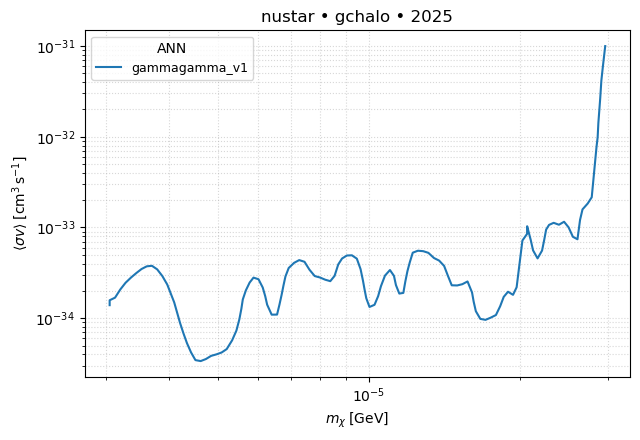

In [12]:
# === Smoke-check: plot newly created ECSV files (this run only) ===
from astropy.table import Table
import matplotlib.pyplot as plt

if not NEW_ECSV:
    print("No newly created ECSV files to plot.")
else:
    # split by mode (ann vs dec) based on meta['mode'] in each file
    groups = {"ann": [], "dec": []}
    for p in NEW_ECSV:
        t = Table.read(p, format="ascii.ecsv")
        mode = str(t.meta.get("mode", "ann"))
        groups["dec" if mode == "dec" else "ann"].append((p, t))

    for mode, items in groups.items():
        if not items:
            continue
        plt.figure(figsize=(6.5, 4.5))
        for p, t in items:
            x = t["mass"]
            if "sigma_v" in t.colnames:
                y = t["sigma_v"]
                ylab = r"$\langle\sigma v\rangle\;[\mathrm{cm^3\,s^{-1}}]$"
            else:
                y = t["lifetime"]
                ylab = r"$\tau\;[\mathrm{s}]$"

            # label: channel + optional variant from meta
            ch = str(t.meta.get("channel", ""))
            var = str(t.meta.get("variant", "") or "")
            lab = f"{ch}" + (f"_{var}" if var else "")

            plt.loglog(x, y, label=lab)

        plt.xlabel(r"$m_\chi\;[\mathrm{GeV}]$")
        plt.ylabel(ylab)
        plt.grid(True, which="both", ls=":", alpha=0.5)
        plt.legend(title=mode.upper(), fontsize=9)
        # try to derive a compact title from meta of the first table
        first_meta = items[0][1].meta
        title = f"{first_meta.get('instrument','')} • {first_meta.get('target','')} • {first_meta.get('year','')}"
        plt.title(title)

        # save next to OUT (optional) and show
        out_png = OUT / f"smoke_{first_meta.get('instrument','')}_{first_meta.get('target','')}_{mode}.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=150)
        print(f"Saved plot → {out_png}")
        plt.show()